<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Regularization/dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dropout

In [27]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import time

## Settings and Dataset

In [28]:
## Settings 
random_seed = 123
batch_size = 256
num_hidden_1 = 75
num_hidden_2 = 65
drop_proba = 0.5
num_epochs = 35
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
train_indices = torch.arange(1000, 60000)
valid_indices = torch.arange(1000)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

training_transform = transforms.Compose([
        # transforms.Resize(size=(32, 32)),
        # transforms.RandomCrop(size=(28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))])

valid_transform = transforms.Compose([
        # transforms.Resize(size=(32, 32)),
        # transforms.RandomCrop(size=(28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root="data",
                               train=True,
                               transform=training_transform,
                               download=True)

valid_dataset = datasets.MNIST(root="data",
                               train=True,
                               transform=valid_transform,
                               download=False)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=valid_transform,
                              download=False)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          drop_last=True,
                          sampler=train_sampler,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          num_workers=4,
                          sampler=valid_sampler)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         num_workers=4,
                         shuffle=False)


In [30]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.

    for i, (features, targets) in enumerate(data_loader):
        features = features.view(-1, 28*28)
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += torch.sum(targets == predicted_labels)
    return correct_pred.float() / num_examples * 100, cross_entropy / num_examples

# No Dropout

In [6]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes,
                 num_hidden_1, num_hidden_2):
        super(MultilayerPerceptron, self).__init__()

        self.my_network = torch.nn.Sequential(
        torch.nn.Linear(num_features, num_hidden_1),
        torch.nn.ReLU(),
        torch.nn.Linear(num_hidden_1, num_hidden_2),
        torch.nn.ReLU(),
        torch.nn.Linear(num_hidden_2, num_classes)
    )
    
    def forward(self, x):
        logits = self.my_network(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [8]:
## Model Initialization 

torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=28*28,
                             num_classes=10,
                             num_hidden_1=num_hidden_1,
                             num_hidden_2=num_hidden_2)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Training

start_time = time.time()
train_acc_1st, valid_acc_1st = [], []
train_loss_1st, valid_loss_1st = [], []

for epoch in range(num_epochs):

    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        ## Prepare minibatch
        features = features.view(-1, 28*28)
        features = features.to(device)
        targets = targets.to(device)

        ## forward and back prop
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        # update model
        optimizer.step()

        ## logging 
        if not batch_idx % 120:
            print(f"Epoch: {epoch+1:03d}/{num_epochs:03d} | "
                  f"Batch: {batch_idx:03d}/{len(train_loader):03d} | "
                  f"Cost: {cost:.4f}")
    
    ## no need to build the computational graph for back prop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=device)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=device)

        train_acc_1st.append(train_acc)
        valid_acc_1st.append(valid_acc)
        train_loss_1st.append(train_loss)
        valid_loss_1st.append(valid_loss)
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d} Train Acc.: {train_acc:.2f}%"
              f" | Validation Acc.: {valid_acc:.2f}%")
    
    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
ptiny(f"Total Training Time: {elapsed:.2f} min")

Epoch: 001/035 | Batch: 000/230 | Cost: 2.3047
Epoch: 001/035 | Batch: 120/230 | Cost: 0.4473
Epoch: 001/035 Train Acc.: 88.85% | Validation Acc.: 88.70%
Time elapsed: 1.28 min
Epoch: 002/035 | Batch: 000/230 | Cost: 0.3442
Epoch: 002/035 | Batch: 120/230 | Cost: 0.3084
Epoch: 002/035 Train Acc.: 92.61% | Validation Acc.: 92.60%
Time elapsed: 2.59 min
Epoch: 003/035 | Batch: 000/230 | Cost: 0.2228
Epoch: 003/035 | Batch: 120/230 | Cost: 0.2208
Epoch: 003/035 Train Acc.: 94.05% | Validation Acc.: 93.90%
Time elapsed: 3.90 min
Epoch: 004/035 | Batch: 000/230 | Cost: 0.1559
Epoch: 004/035 | Batch: 120/230 | Cost: 0.2255
Epoch: 004/035 Train Acc.: 94.36% | Validation Acc.: 93.70%
Time elapsed: 5.21 min
Epoch: 005/035 | Batch: 000/230 | Cost: 0.1892
Epoch: 005/035 | Batch: 120/230 | Cost: 0.2120
Epoch: 005/035 Train Acc.: 95.55% | Validation Acc.: 94.90%
Time elapsed: 6.50 min
Epoch: 006/035 | Batch: 000/230 | Cost: 0.1225
Epoch: 006/035 | Batch: 120/230 | Cost: 0.1453
Epoch: 006/035 Train 

NameError: ignored

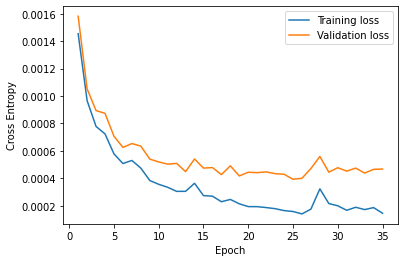

In [9]:
plt.plot(range(1, num_epochs+1), train_loss_1st, label='Training loss')
plt.plot(range(1, num_epochs+1), valid_loss_1st, label="Validation loss")
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [11]:
model.eval()
with torch.set_grad_enabled(False):
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}")

Test Accuracy: 97.23


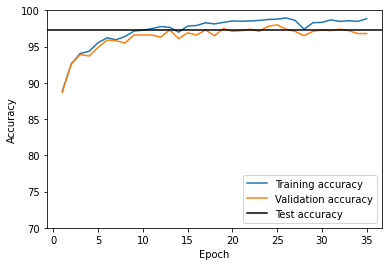

In [12]:
plt.plot(range(1, num_epochs+1), train_acc_1st, label='Training accuracy')
plt.plot(range(1, num_epochs+1), valid_acc_1st, label='Validation accuracy')
plt.axhline(y=test_acc, c='black', label='Test accuracy')
plt.ylim([70, 100])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Object Oriented Dropout

In [9]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28)
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples



In [10]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes, drop_proba,
                 num_hidden_1, num_hidden_2):
        super(MultilayerPerceptron, self).__init__()

        self.my_network = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            torch.nn.Linear(num_hidden_2, num_classes),
        )

    def forward(self, x):
        logits = self.my_network(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [11]:
#################################
### Model Initialization
#################################
    
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=num_hidden_1,
                             num_hidden_2=num_hidden_2,
                             drop_proba=drop_proba,
                             num_classes=10)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#################################
### Training
#################################

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(num_epochs):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28)
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{num_epochs:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | ' 
                   f'Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=device)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=device)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/035 | Batch 000/230 | Cost: 2.3101
Epoch: 001/035 | Batch 120/230 | Cost: 0.9171
Epoch: 001/035 Train Acc.: 87.56% | Validation Acc.: 86.70%
Time elapsed: 1.18 min
Epoch: 002/035 | Batch 000/230 | Cost: 0.7002
Epoch: 002/035 | Batch 120/230 | Cost: 0.5771
Epoch: 002/035 Train Acc.: 90.18% | Validation Acc.: 90.40%
Time elapsed: 2.36 min
Epoch: 003/035 | Batch 000/230 | Cost: 0.5677
Epoch: 003/035 | Batch 120/230 | Cost: 0.5330
Epoch: 003/035 Train Acc.: 91.31% | Validation Acc.: 90.40%
Time elapsed: 3.54 min
Epoch: 004/035 | Batch 000/230 | Cost: 0.4534
Epoch: 004/035 | Batch 120/230 | Cost: 0.5612
Epoch: 004/035 Train Acc.: 91.77% | Validation Acc.: 91.00%
Time elapsed: 4.72 min
Epoch: 005/035 | Batch 000/230 | Cost: 0.5241
Epoch: 005/035 | Batch 120/230 | Cost: 0.4920
Epoch: 005/035 Train Acc.: 92.98% | Validation Acc.: 92.80%
Time elapsed: 5.89 min
Epoch: 006/035 | Batch 000/230 | Cost: 0.3592
Epoch: 006/035 | Batch 120/230 | Cost: 0.3709
Epoch: 006/035 Train Acc.: 93.49%

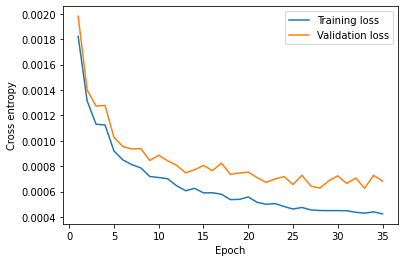

In [12]:
plt.plot(range(1, num_epochs+1), train_loss_lst, label='Training loss')
plt.plot(range(1, num_epochs+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [13]:
model.eval()
with torch.set_grad_enabled(False):
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device)
    print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 96.08%


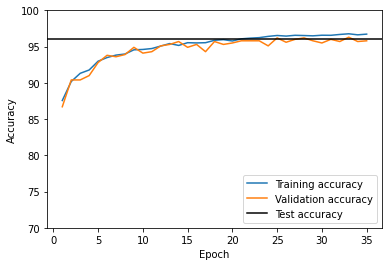

In [14]:
plt.plot(range(1, num_epochs+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, num_epochs+1), valid_acc_lst, label='Validation accuracy')
plt.axhline(y=test_acc, c='black', label='Test accuracy')
plt.ylim([70, 100])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Functional API Dropout

In [35]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes,
                 drop_proba, num_hidden_1, num_hidden_2):
        super(MultilayerPerceptron, self).__init__()

        self.drop_proba = drop_proba
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = F.dropout(out, p=self.drop_proba, training=self.training)
        out = self.linear_2(out)
        out = F.relu(out)
        out = F.dropout(out, p=self.drop_proba, training=self.training)
        logits = self.linear_out(out)
        probas = F.log_softmax(logits, dim=1)
        return logits, probas

In [36]:
## Model Initialization 

torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=28*28,
                             num_classes=10,
                             drop_proba=drop_proba,
                             num_hidden_1=num_hidden_1,
                             num_hidden_2=num_hidden_2)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Training

start_time = time.time()
train_acc_1st, valid_acc_1st = [], []
train_loss_1st, valid_loss_1st = [], []

for epoch in range(num_epochs):

    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        ## Prepare minibatch
        features = features.view(-1, 28*28)
        features = features.to(device)
        targets = targets.to(device)

        ## forward and back prop
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        # update model
        optimizer.step()

        ## logging 
        if not batch_idx % 120:
            print(f"Epoch: {epoch+1:03d}/{num_epochs:03d} | "
                  f"Batch: {batch_idx:03d}/{len(train_loader):03d} | "
                  f"Cost: {cost:.4f}")
    
    ## no need to build the computational graph for back prop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=device)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=device)

        train_acc_1st.append(train_acc)
        valid_acc_1st.append(valid_acc)
        train_loss_1st.append(train_loss)
        valid_loss_1st.append(valid_loss)
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d} Train Acc.: {train_acc:.2f}%"
              f" | Validation Acc.: {valid_acc:.2f}%")
    
    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")

Epoch: 001/035 | Batch: 000/230 | Cost: 2.3101
Epoch: 001/035 | Batch: 120/230 | Cost: 0.9171
Epoch: 001/035 Train Acc.: 87.56% | Validation Acc.: 86.70%
Time elapsed: 1.15 min
Epoch: 002/035 | Batch: 000/230 | Cost: 0.7002
Epoch: 002/035 | Batch: 120/230 | Cost: 0.5771
Epoch: 002/035 Train Acc.: 90.18% | Validation Acc.: 90.40%
Time elapsed: 2.29 min
Epoch: 003/035 | Batch: 000/230 | Cost: 0.5677
Epoch: 003/035 | Batch: 120/230 | Cost: 0.5330
Epoch: 003/035 Train Acc.: 91.31% | Validation Acc.: 90.40%
Time elapsed: 3.46 min
Epoch: 004/035 | Batch: 000/230 | Cost: 0.4534
Epoch: 004/035 | Batch: 120/230 | Cost: 0.5612
Epoch: 004/035 Train Acc.: 91.77% | Validation Acc.: 91.00%
Time elapsed: 4.61 min
Epoch: 005/035 | Batch: 000/230 | Cost: 0.5241
Epoch: 005/035 | Batch: 120/230 | Cost: 0.4920
Epoch: 005/035 Train Acc.: 92.98% | Validation Acc.: 92.80%
Time elapsed: 5.76 min
Epoch: 006/035 | Batch: 000/230 | Cost: 0.3592
Epoch: 006/035 | Batch: 120/230 | Cost: 0.3709
Epoch: 006/035 Train 

In [48]:
len(train_loss_1st)

35

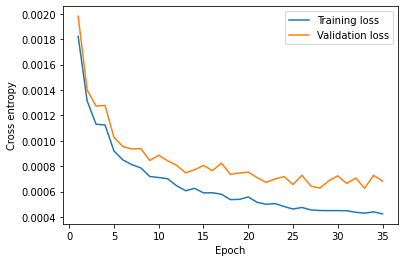

In [51]:
plt.plot(range(1, num_epochs+1), train_loss_1st, label='Training loss')
plt.plot(range(1, num_epochs+1), valid_loss_1st, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [52]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 96.08%


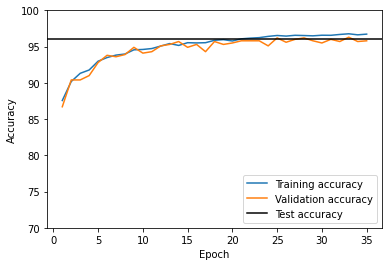

In [55]:
plt.plot(range(1, num_epochs+1), train_acc_1st, label='Training accuracy')
plt.plot(range(1, num_epochs+1), valid_acc_1st, label='Validation accuracy')
plt.axhline(y=test_acc, c='black', label='Test accuracy')
plt.ylim([70, 100])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()